In [ ]:
!git clone https://github.com/asmcleod/NearFieldOptics
!git clone https://github.com/asmcleod/common

Cloning into 'NearFieldOptics'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 349 (delta 15), reused 25 (delta 7), pack-reused 308
Receiving objects: 100% (349/349), 48.85 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Cloning into 'common'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.


In [ ]:
from google.colab import drive # nxNxN
drive.mount('/content/drive/')

In [ ]:
from __future__ import print_function

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pandas as pd
from tqdm import tqdm

from NearFieldOptics import Materials as M

E_F = 0
T = 300 
hbar = 1.05457181765e-34
k_b = 1.38064852e-23
scale = 2060000000

def func(E):
    return 1.0/(1+np.exp((E-E_F)/(T*k_b)))

def fdash(E): #derivative wrt E
    return -1/(T*k_b)*np.exp((E-E_F)/(T*k_b))/(1+np.exp((E-E_F)/(T*k_b)))**2

In [ ]:
deltas = np.linspace(0,1.2,7)
mus = np.linspace(0,0.5,6)
with open('/content/drive/My Drive/CMP Superconductivity/big data/eigenvalue dict (monolayer onsite spin singlet) nspin=1','rb') as f:
    eval_dict = pickle.load(f)
with open('/content/drive/My Drive/CMP Superconductivity/big data/eigenvector dict (monolayer onsite spin singlet) nspin=1','rb') as f:
    evec_dict = pickle.load(f)

In [ ]:
def getEigen(delta=0.0,mu=0.0):

    e_val,e_vec = eval_dict[(delta,mu)],evec_dict[(delta,mu)]
    
    eigenval = e_val.reshape(8,100,100)
    eigenvec = e_vec.reshape(8,100,100,8)

    return eigenval, eigenvec

In [ ]:
x1,x2=getEigen()

## Kubo Formula

In [ ]:
constants = 1j # fitting-ish parameter

def kubo_arr(E, evec, omega, Gamma):
    conductivity = np.zeros(shape=(omega.shape),dtype=complex)
    for i in tqdm(range(len(omega))): #get conductivity for each omega
        ku=0
        for n in range(len(E)): #band index n
            for m in range(len(E)): #band index m
                halfdot = np.conj(evec[n])*np.flip(evec[m].reshape(100,100,4,2),axis=-1).reshape(100,100,8)
                dotprod = np.sum(halfdot, axis = -1)
                spinfrac = (np.absolute(dotprod))**2
                
                if n!=m:
                    if(len(np.where(E[m]-E[n]==0)[0])>0): #if bands are degenerate or "intersect"
                        #print(n,m,'dirac cone')
                        contribution = -fdash(E[n]) #sure about this?
                    else:
                        #print(n,m,'interband contribution')
                        contribution = (func(E[n])-func(E[m]))/(E[m]-E[n])
                else:
                    contribution = -fdash(E[n])
                    #print(n,m,'INTRABAND contribution')

                ku += constants*contribution*spinfrac/(hbar*omega[i]+Gamma*1j-E[m]+E[n])
        conductivity[i]=np.sum(ku)
            
    return conductivity

100%|██████████| 200/200 [00:40<00:00,  5.00it/s]

0.0 0.0


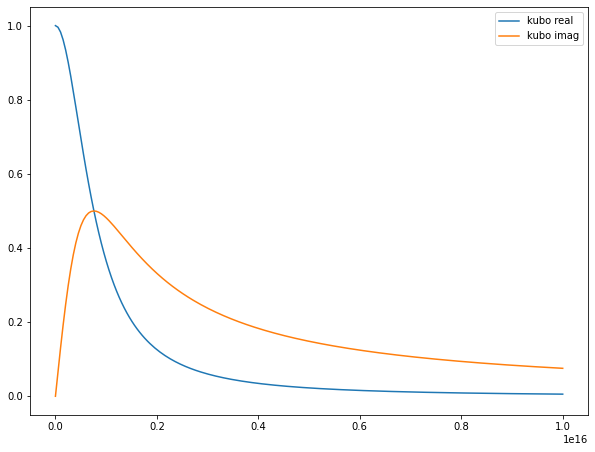

In [ ]:
delta,mu=0.0,0.0
gamma = 0.5
freq = np.linspace(0,1e16,200)

S = M.SingleLayerGraphene(gamma = gamma)

eigenval, eigenvec = getEigen(delta,mu)
eigenval*=1.6e-19

sigs = S.conductivity(freq)
sigma = kubo_arr(eigenval, eigenvec, freq, gamma*1.6e-19)

print(delta,mu)

plt.figure(figsize=(10,7.5))
plt.plot(freq, sigma.real/sigma.real[0], label = 'kubo real')
plt.plot(freq, sigma.imag/sigma.real[0], label = 'kubo imag')
'''
plt.plot(freq, sigs.real, label = 'real')
plt.plot(freq, sigs.imag, label = 'imag')
'''

plt.legend()
plt.show()

In [ ]:
#@title Qualitative Conductivity- Sanity Check
gamma = 5 #@param
gamma = gamma*1.6e-19
freq = np.linspace(0,1e17,200)

for delta in np.round(deltas,decimals=1):
    for mu in np.round(mus,decimals=1):
        eigenval, eigenvec = getEigen(delta,mu)
        eigenval*=1.6e-19
        sigma = kubo_arr(eigenval, eigenvec, freq, gamma)

        print(delta,mu)
        plt.plot(freq, sigma.real)
        plt.plot(freq, sigma.imag)
        plt.show()

In [ ]:
#@title Band Structure- Sanity Check
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
N = 100

x = y = np.linspace(-N//2, N//2, N)
k_X, k_Y = np.meshgrid(x, y)

ax.plot_wireframe(k_X, k_Y, eigenval[0])
ax.plot_wireframe(k_X, k_Y, eigenval[4],0.75,color='orange')

In [ ]:
def getConductivity(freq = np.linspace(0,3000,1500),delta=0.0, mu=0.0, Gamma = 10):
    eigenval, eigenvec = getEigen(delta, mu)
    sigma = kubo_arr(eigenval, eigenvec, freq, Gamma)
    return sigma*scale
 
def getPlasmon(freq = np.linspace(0,3000,1500), delta=0.0, mu=0.0, frequency = 30, q = np.linspace(1,2.5e6,1500), Gamma = 10):
    sigma = getConductivity(freq, delta, mu, Gamma)
    
    df = pd.DataFrame({"freq" : freq, "real" : sigma.real, "imag" : sigma.imag})
    df.to_csv("temp.csv", index=False)
 
    surface = M.TabulatedSurfaceFromFile('temp.csv')
 
    rp = surface.reflection_p(frequency,q)
    rp = rp.T
 
    #np.imag(rp).plot()
 
    peaks = find_peaks(np.imag(rp))[0]
 
    FWHM = peak_widths(np.imag(rp),peaks)
    print(delta,mu)
    print('plasmon wavelength:',2*np.pi/np.imag(rp)[peaks])
    print('FWHM:',FWHM[0])
 
    return 2*np.pi/np.imag(rp)[peaks], FWHM[0]

In [ ]:
def getPlasmonWavelength(freq = np.linspace(0,3000,1500), delta=0.0,mu=0.0, frequency = 30, q = np.linspace(1,2.5e6,1500), Gamma = 10):
    wavelength, FWHM = getPlasmon(freq, delta, mu, frequency, q, Gamma)
    return wavelength

def getPlasmonFWHM(freq = np.linspace(0,3000,1500),delta=0.0, mu=0.0, frequency = 30, q = np.linspace(1,2.5e6,1500), Gamma = 10):
    wavelength, FWHM = getPlasmon(freq, delta, mu, frequency, q, Gamma)
    return FWHM

## Final Colormap


In [ ]:
freqo = 30
qu = np.linspace(1,2.5e6,1500)
gam = 10
freqarr = np.linspace(0,3000,50)

In [ ]:
wvdata = np.zeros(shape=(len(mus),len(deltas))) #BE CAREFUL- SHAPE = y,x
FWHMdata = np.zeros(shape=(len(mus),len(deltas))) #BE CAREFUL- SHAPE = y,x

for i in range(len(deltas)):
    for j in range(len(mus)):
        wvdata[j][i] = np.mean(getPlasmonWavelength(freq = freqarr, delta = np.round(deltas, decimals=1)[i], mu = np.round(mus, decimals=1)[j], frequency = freqo, q = qu, Gamma = gam)) #remove max 
        FWHMdata[j][i] = np.mean(getPlasmonFWHM(freq = freqarr, delta = np.round(deltas, decimals=1)[i], mu = np.round(mus, decimals=1)[j], frequency = freqo, q = qu, Gamma = gam))

<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<ipython-input-14-57a60fb0f0af>:5: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('Chemical Potential ($\mu$)')
<ipyt

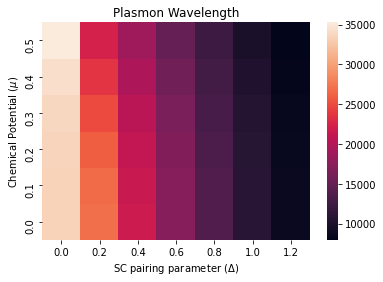

In [ ]:
axwv = sns.heatmap(wvdata, xticklabels=np.round(deltas, decimals=1), yticklabels=np.round(mus, decimals=1))
axwv.invert_yaxis()

plt.title('Plasmon Wavelength')
plt.ylabel('Chemical Potential ($\mu$)')
plt.xlabel('SC pairing parameter ($\Delta$)')
plt.show()

<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<input>:5: DeprecationWarning: invalid escape sequence \m
<input>:6: DeprecationWarning: invalid escape sequence \D
<ipython-input-15-8fedb0be14d9>:5: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('Chemical Potential ($\mu$)')
<ipyt

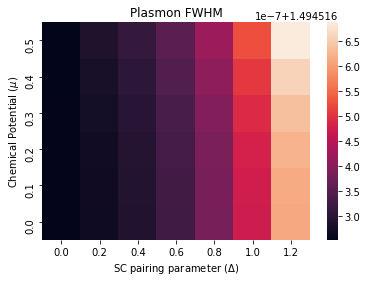

In [ ]:
axFWHM = sns.heatmap(FWHMdata, xticklabels=np.round(deltas, decimals=1), yticklabels=np.round(mus, decimals=1))
axFWHM.invert_yaxis()

plt.title('Plasmon FWHM')
plt.ylabel('Chemical Potential ($\mu$)')
plt.xlabel('SC pairing parameter ($\Delta$)')
plt.show()